In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
import json
from PIL import ImageFont, ImageDraw, Image
from google.cloud import vision
from sklearn.cluster import DBSCAN
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
import io
import re
from google.oauth2 import service_account
import layoutparser as lp
from google.protobuf.json_format import MessageToJson
import proto
from scipy.signal import find_peaks
os.environ['KMP_DUPLICATE_LIB_OK']='True'


dir_data = 'C:/Users/Antonin_JOLY/Desktop/Projects/cash b/data/gcp/label'
dir_img = 'C:/Users/Antonin_JOLY/Desktop/Projects/cash b/data/homography'

accepted = ['.jpg','.jpeg','.png']

# Retrieve data

In [2]:
data_path = [os.path.join(dir_data, i) for i in os.listdir(dir_data)]

for idx, excel_path in enumerate(data_path):
    xls = pd.ExcelFile(excel_path)
    names = [i for i in xls.sheet_names if i.isdigit()]
    
    if idx==0:
        df = xls.parse(names[0], header=2)
    for n in names[1:]:
        df =pd.concat([df, xls.parse(n, header=2)], axis=0)

# Drop columns with only Nan values
df = df.dropna(axis=1, how='all')

# Retrieve img path in evaluation folder
list_path = [os.path.join(dir_img, i) for i in os.listdir(dir_img) if os.path.splitext(i)[1].lower() in accepted]
list_path_single = [i for i in list_path if 'homography' not in os.path.basename(i)]

eval_path = [i for i in list_path_single if os.path.basename(i) in df['画像名'].to_list()]
img_path = sorted(eval_path + [os.path.splitext(i)[0] + '_homography.' + os.path.splitext(i)[1] for i in eval_path])
img_path = [i for i in img_path if i in list_path]

# Modify df so it only contains relevant entries
df = df[df['画像名'].isin([os.path.basename(i) for i in eval_path])].reset_index()

# Display basic infor and head of df
df.info()
df.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Columns: 329 entries, index to 単価.52
dtypes: datetime64[ns](1), float64(136), int64(2), object(190)
memory usage: 2.4+ MB


,index,データ番号,画像名,企業名,店舗名,店舗電話番号,店舗住所,購入日,購入時間,総額・合計(税込),総額・合計(税額),レシート番号,決済方法,ポイントカード情報,商品名,JAN,購入点数,単価,割引単価,価格,割引価格,商品名.1,JAN.1,購入点数.1,単価.1,割引単価.1,価格.1,割引価格.1,商品名.2,JAN.2,購入点数.2,単価.2,割引単価.2,価格.2,割引価格.2,商品名.3,JAN.3,購入点数.3,単価.3,割引単価.3,価格.3,割引価格.3,商品名.4,JAN.4,購入点数.4,単価.4,割引単価.4,価格.4,割引価格.4,商品名.5,JAN.5,購入点数.5,単価.5,割引単価.5,価格.5,割引価格.5,商品名.6,JAN.6,購入点数.6,単価.6,割引単価.6,価格.6,割引価格.6,商品名.7,JAN.7,購入点数.7,単価.7,割引単価.7,価格.7,割引価格.7,商品名.8,JAN.8,購入点数.8,単価.8,割引単価.8,価格.8,割引価格.8,商品名.9,JAN.9,購入点数.9,単価.9,割引単価.9,価格.9,割引価格.9,商品名.10,JAN.10,購入点数.10,単価.10,割引単価.10,価格.10,割引価格.10,商品名.11,JAN.11,購入点数.11,単価.11,割引単価.11,価格.11,割引価格.11,商品名.12,JAN.12,購入点数.12,単価.12,割引単価.12,価格.12,割引価格.12,商品名.13,JAN.13,購入点数.13,単価.13,割引単価.13,価格.13,割引価格.13,商品名.14,JAN.14,購入点数.14,単価.14,割引単価.14,価格.14,割引価格.14,商品名.15,JAN.15,購入点数.15,単価.15,割引単価.15,価格.15,割引価格.15,商品名.16,JAN.16,購入点数.16,単価.16,割引単価.16,価格.16,割引価格.16,商品名.17,JAN.17,購入点数.17,単価.17,割引単価.17,価格.17,割引価格.17,商品名.18,JAN.18,購入点数.18,単価.18,割引単価.18,価格.18,割引価格.18,商品名.19,JAN.19,購入点数.19,単価.19,割引単価.19,価格.19,割引価格.19,商品名.20,JAN.20,購入点数.20,単価.20,割引単価.20,価格.20,割引価格.20,商品名.21,JAN.21,購入点数.21,単価.21,割引単価.21,価格.21,割引価格.21,商品名.22,JAN.22,購入点数.22,単価.22,割引単価.22,価格.22,割引価格.22,商品名.23,JAN.23,購入点数.23,単価.23,割引単価.23,価格.23,割引価格.23,商品名.24,JAN.24,購入点数.24,単価.24,割引単価.24,価格.24,割引価格.24,商品名.25,JAN.25,購入点数.25,単価.25,割引単価.25,価格.25,割引価格.25,商品名.26,JAN.26,購入点数.26,単価.26,割引単価.26,価格.26,割引価格.26,商品名.27,JAN.27,購入点数.27,単価.27,割引単価.27,価格.27,割引価格.27,商品名.28,JAN.28,購入点数.28,単価.28,割引単価.28,価格.28,割引価格.28,商品名.29,JAN.29,購入点数.29,単価.29,割引単価.29,価格.29,割引価格.29,商品名.30,JAN.30,購入点数.30,単価.30,割引単価.30,価格.30,商品名.31,JAN.31,購入点数.31,単価.31,割引単価.31,価格.31,割引価格.31,商品名.32,JAN.32,購入点数.32,単価.32,割引単価.32,価格.32,商品名.33,JAN.33,購入点数.33,単価.33,価格.33,商品名.34,JAN.34,購入点数.34,単価.34,割引単価.34,価格.34,商品名.35,JAN.35,購入点数.35,単価.35,割引単価.35,価格.35,商品名.36,JAN.36,購入点数.36,単価.36,価格.36,商品名.37,JAN.37,購入点数.37,単価.37,価格.37,商品名.38,JAN.38,購入点数.38,単価.38,割引単価.38,価格.38,商品名.39,JAN.39,購入点数.39,単価.39,価格.39,商品名.40,JAN.40,購入点数.40,単価.40,価格.40,商品名.41,JAN.41,購入点数.41,単価.41,価格.41,割引価格.41,商品名.42,JAN.42,購入点数.42,単価.42,価格.42,商品名.43,JAN.43,単価.43,割引単価.43,商品名.44,JAN.44,単価.44,割引単価.44,商品名.45,JAN.45,購入点数.45,単価.45,割引単価.45,価格.45,商品名.46,購入点数.46,単価.46,価格.46,商品名.47,購入点数.47,単価.47,価格.47,商品名.48,単価.48,商品名.49,単価.49,商品名.50,単価.50,商品名.51,単価.51,商品名.52,単価.52
0,0,1,2993938-receipt-11e45fc2-88f4-4b6e-8958-e297e3...,NaN,NaN,NaN,NaN,2019-04-05,11:40:00,1652.0,122.0,NaN,NaN,NaN,Fｺﾝﾄﾞｳｷﾞｭｳﾆｭｳ1000ml,NaN,NaN,159.0,NaN,NaN,NaN,Fk ﾁｮｳｾｲﾄｳﾆｭｳ 1000ml,NaN,NaN,149.0,NaN,NaN,NaN,Fﾎｳﾚﾝｿｳ,NaN,2.0,98.0,NaN,196.0,NaN,Fﾐﾂｶﾝﾖｰｸﾞﾙﾄ ｽﾄﾚｰﾄ1L,NaN,NaN,239.0,NaN,NaN,NaN,Fﾐﾂｶﾝﾘﾝｺﾞｸﾛｽﾞｽﾄﾚ1L,NaN,NaN,239.0,NaN,NaN,NaN,Fｺｸｻﾝﾜｶﾄﾞﾘﾓﾓ1ｴｺﾊﾟｯｸ,NaN,NaN,379.0,NaN,NaN,NaN,Fﾏﾙﾎ ﾕｳｷｷﾘﾎﾞｼﾀﾞｲｺﾝ80g,NaN,NaN,120.0,NaN,NaN,NaN,Fｱｻﾋｺ ﾑｶｼｱｹﾞ2ﾏｲ,NaN,NaN,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,3002675-receipt-2063c2ff-09f4-4a96-83df-04c307...,オーケー,港北北山田,045-590-4781,NaN,2019-04-07,17:00:00,12166.0,901.0,9505.0,NaN,NaN,Fｼﾝｼﾞｮｳ ﾐｿﾑﾃﾝｶﾅﾏ1kg,NaN,NaN,569.0,NaN,NaN,NaN,Fﾔﾏｻｼｮｳﾕ ﾎﾟﾘﾋﾞﾝ 1L,NaN,NaN,162.0,NaN,NaN,NaN,ﾊｸﾂﾙ ｻｹﾊﾟｯｸﾏﾙ 2L,NaN,NaN,838.0,NaN,NaN,NaN

# Get OCR from images

In [112]:
def detect_text(path, client, df):
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations[1:]
    img = cv2.imread(path, cv2.IMREAD_COLOR)[:, :, [2, 1, 0]]
    img = np.ascontiguousarray(img)
    
    for text in texts:
        vertices = [(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices]
        cv2.rectangle(img, vertices[0], vertices[2], (0, 255, 0),2)
        print('\n"{}"'.format(text.description))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

    return img, proto.Message.to_json(response), texts

def find_offset_angle(angle):
    if angle < 45 and angle > -45:
        offset_angle = 0
    elif angle > 45:
        offset_angle = 90
    elif angle < -45:
        offset_angle = -90
    return offset_angle

def rotation_matrix(rect):
    center, angle = rect[0], rect[2]
    offset_angle = find_offset_angle(angle)
    rot = cv2.getRotationMatrix2D(center, angle-offset_angle, 1)
    return rot

def line_cluster(pts, d):
    X = pts.copy()
    X[:,0] = 0
    
    x_p, y_p = np.array(range(len(X[:,1]))), np.array(sorted(X[:,1]))
    res_p = np.gradient(y_p)*10
    peaks, _ = find_peaks(res_p, prominence=50)
    
    clustering = DBSCAN(eps=len(peaks)/d, min_samples=3, metric='l1').fit(X)
    labels = clustering.labels_
    return labels, labels.copy().reshape(-1,3)[:,0], x_p, y_p, res_p, peaks

def visualize_cls(img, img_pts, img_line, x_p, y_p, res_p, peaks):
    fig = plt.figure(figsize=(15,12))
    grid = plt.GridSpec(2, 3, height_ratios=[5, 2])

    plt.subplot(grid[0, 0])
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(grid[0, 1])
    plt.imshow(img_pts)
    plt.axis('off')

    plt.subplot(grid[0, 2])
    plt.imshow(img_line)
    plt.axis('off')

    plt.subplot(grid[1,:])
    plt.plot(x_p, y_p)
    plt.plot(x_p, res_p)
    plt.plot(peaks, res_p[peaks], "x")
    plt.plot(peaks, y_p[peaks], "x")

    plt.tight_layout()

    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    vis = data.reshape((int(h), int(w), -1))[:, :, [2, 1, 0]]
    plt.close()
    
    return vis

def process_text(path, text, df, img_res):
    img = cv2.imread(path)[:,:, ::-1]
    
    pts, bbox_id, text_id, cnt, text_res = [], [], [], [], []
    for idx, t in enumerate(text):
        vrt = np.array([[vertex.x, vertex.y] for vertex in t.bounding_poly.vertices])
        cnt.append(vrt)
        pts.append([list(np.mean(vrt[[0,3],:],axis=0).astype(int)),
                    list(np.mean(vrt[:,:],axis=0).astype(int)),
                    list(np.mean(vrt[[1,2],:],axis=0).astype(int))])
        bbox_id.append([idx, idx, idx])
        text_id.append(t.description)
    
    pts = np.array(pts).reshape(-1,2)
    center = pts.reshape(-1,3,2)[:,1,:]
    bbox_id = np.array(bbox_id).reshape(-1,1)
    text_id = np.array(text_id).reshape(-1,1)
    
    rect = cv2.minAreaRect(np.array(cnt).reshape(-1,2))
    box = np.int0(cv2.boxPoints(rect))
    # rot = rotation_matrix(rect)
    # pts_expand = np.hstack([pts, np.ones(shape=(pts.shape[0], 1))])

    # # img = cv2.warpAffine(img, rot, (img.shape[1], img.shape[0]))
    # # pts_bbox = np.uint(rot.dot(pts_expand.T).T) # Rotate points
    # # pts_bbox = pts.copy()
    
    # Points preparation
    img_pts = np.ascontiguousarray(img_res.copy())
    for pt in pts:
        img_pts = cv2.circle(img_pts, (pt[0],pt[1]), radius=0, color=(255, 0, 0), thickness=6)
    img_pts = cv2.drawContours(img_pts,[box],0,(0,0,255),10)
    
    # Clustering
    labels, labels_word, x_p, y_p, res_p, peaks = line_cluster(pts, 3)
    colors = [(np.random.choice(range(256), size=3)).tolist() for i in range(len(np.unique(labels)))]
    
    img_line = np.ascontiguousarray(img.copy())
    
    for idx, (l,c) in enumerate(zip(np.unique(labels),colors)):
        pt = pts[labels==l]
        img_line = cv2.polylines(img_line, np.int32([pt]), 0, c, 6)

        x = center[labels_word==l][:,0]
        y = center[labels_word==l][:,1]
        words = text_id[labels_word==l]
        res = sorted([(i, np.mean(y,axis=0), k[0]) for i,j,k in zip(x,y,words)], key=lambda tup: tup[0])
        text_res.append(res)
    
    img_res = visualize_cls(img, img_pts, img_line, x_p, y_p, res_p, peaks)
    
    text_res = [(np.mean([j[1] for j in i]),[j[2] for j in i]) for i in text_res]
    text_res = sorted(text_res, key=lambda tup: tup[0])
    text_res = [i[1] for i in text_res]
    
    return img_res, text_res

In [113]:
dir_res = 'C:/Users/Antonin_JOLY/Desktop/Projects/cash b/data/gcp/res'
creds = service_account.Credentials.from_service_account_file('../../../keyFile.json')
client = vision.ImageAnnotatorClient(credentials=creds)

test_id = 1049
for idx, path in enumerate(tqdm(img_path[test_id:test_id+1])):

# for idx, path in enumerate(tqdm(img_path)):
    img_res, raw_json, text = detect_text(path, client, df)
    img_res, text_res = process_text(path, text, df, img_res)
    
    cv2.imwrite(os.path.join(dir_res,os.path.basename(path)), img_res)
    fileName, fileExtension = os.path.splitext(os.path.basename(path))
    with open(os.path.join(dir_res, fileName + '.json'), 'w') as outfile:
        json.dump(raw_json, outfile)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


"食生活"

"●"

"V"

"ロピア"

"ロピア"

"TOKYO"

"-"

"BAY"

"店"

"a"

"047-404-8500"

"2019"

"年"

"04"

"月"

"14"

"日"

"("

"日"

")"

"17:03"

"レジ"

"0007"

"責"

"NO00022080"

"山口"

"穀物"

"肥育"

"牛"

"モモ"

"ステーキ"

"¥"

"1,051"

"シマホッケ"

"千物"

"ハンバーガー"

"N"

"テリヤキ"

"ハンバーガー"

"("

"¥"

"89"

"グリコ"

"Bifix"

"YG"

"脂肪"

"ゼロ"

"チョコ"

"&"

"チョコ"

"デニッシュ"

"¥"

"89"

"銀鮭"

"("

"甘口"

")"

"タカノ"

"極"

"小粒"

"ミニ"

"3"

"2"

"コ"

"X"

"単"

"55"

"¥680"

"¥89"

"¥119"

"¥590"

"長芋"

"("

"パック"

")"

"からっと"

"香ばしい"

"油揚"

"¥110"

"¥230"

"¥69"

"厚"

"肉"

"生"

"しいたけ"

"("

"菌"

"床"

"栽培"

"¥"

"260"

"A"

"ピア"

"お"

"肉屋"

"さん"

"キムチ"

"("

"外"

"税"

"対象"

"外"

"税"

"計"

"("

"消費"

"税"

"等"

"¥189"

"¥3,"

"565)"

"¥285"

"¥285)"

"¥3,"

"850"

"¥3,"

"850"

"合計"

"/"

"13"

"点"

"スマホ"

"決済"

"お"

"釣り"

"レシート"

"NO7159"

"店"

"NO00126"


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


In [114]:
df[df['画像名']==os.path.basename(path).replace('_homography..','.')]

,index,データ番号,画像名,企業名,店舗名,店舗電話番号,店舗住所,購入日,購入時間,総額・合計(税込),総額・合計(税額),レシート番号,決済方法,ポイントカード情報,商品名,JAN,購入点数,単価,割引単価,価格,割引価格,商品名.1,JAN.1,購入点数.1,単価.1,割引単価.1,価格.1,割引価格.1,商品名.2,JAN.2,購入点数.2,単価.2,割引単価.2,価格.2,割引価格.2,商品名.3,JAN.3,購入点数.3,単価.3,割引単価.3,価格.3,割引価格.3,商品名.4,JAN.4,購入点数.4,単価.4,割引単価.4,価格.4,割引価格.4,商品名.5,JAN.5,購入点数.5,単価.5,割引単価.5,価格.5,割引価格.5,商品名.6,JAN.6,購入点数.6,単価.6,割引単価.6,価格.6,割引価格.6,商品名.7,JAN.7,購入点数.7,単価.7,割引単価.7,価格.7,割引価格.7,商品名.8,JAN.8,購入点数.8,単価.8,割引単価.8,価格.8,割引価格.8,商品名.9,JAN.9,購入点数.9,単価.9,割引単価.9,価格.9,割引価格.9,商品名.10,JAN.10,購入点数.10,単価.10,割引単価.10,価格.10,割引価格.10,商品名.11,JAN.11,購入点数.11,単価.11,割引単価.11,価格.11,割引価格.11,商品名.12,JAN.12,購入点数.12,単価.12,割引単価.12,価格.12,割引価格.12,商品名.13,JAN.13,購入点数.13,単価.13,割引単価.13,価格.13,割引価格.13,商品名.14,JAN.14,購入点数.14,単価.14,割引単価.14,価格.14,割引価格.14,商品名.15,JAN.15,購入点数.15,単価.15,割引単価.15,価格.15,割引価格.15,商品名.16,JAN.16,購入点数.16,単価.16,割引単価.16,価格.16,割引価格.16,商品名.17,JAN.17,購入点数.17,単価.17,割引単価.17,価格.17,割引価格.17,商品名.18,JAN.18,購入点数.18,単価.18,割引単価.18,価格.18,割引価格.18,商品名.19,JAN.19,購入点数.19,単価.19,割引単価.19,価格.19,割引価格.19,商品名.20,JAN.20,購入点数.20,単価.20,割引単価.20,価格.20,割引価格.20,商品名.21,JAN.21,購入点数.21,単価.21,割引単価.21,価格.21,割引価格.21,商品名.22,JAN.22,購入点数.22,単価.22,割引単価.22,価格.22,割引価格.22,商品名.23,JAN.23,購入点数.23,単価.23,割引単価.23,価格.23,割引価格.23,商品名.24,JAN.24,購入点数.24,単価.24,割引単価.24,価格.24,割引価格.24,商品名.25,JAN.25,購入点数.25,単価.25,割引単価.25,価格.25,割引価格.25,商品名.26,JAN.26,購入点数.26,単価.26,割引単価.26,価格.26,割引価格.26,商品名.27,JAN.27,購入点数.27,単価.27,割引単価.27,価格.27,割引価格.27,商品名.28,JAN.28,購入点数.28,単価.28,割引単価.28,価格.28,割引価格.28,商品名.29,JAN.29,購入点数.29,単価.29,割引単価.29,価格.29,割引価格.29,商品名.30,JAN.30,購入点数.30,単価.30,割引単価.30,価格.30,商品名.31,JAN.31,購入点数.31,単価.31,割引単価.31,価格.31,割引価格.31,商品名.32,JAN.32,購入点数.32,単価.32,割引単価.32,価格.32,商品名.33,JAN.33,購入点数.33,単価.33,価格.33,商品名.34,JAN.34,購入点数.34,単価.34,割引単価.34,価格.34,商品名.35,JAN.35,購入点数.35,単価.35,割引単価.35,価格.35,商品名.36,JAN.36,購入点数.36,単価.36,価格.36,商品名.37,JAN.37,購入点数.37,単価.37,価格.37,商品名.38,JAN.38,購入点数.38,単価.38,割引単価.38,価格.38,商品名.39,JAN.39,購入点数.39,単価.39,価格.39,商品名.40,JAN.40,購入点数.40,単価.40,価格.40,商品名.41,JAN.41,購入点数.41,単価.41,価格.41,割引価格.41,商品名.42,JAN.42,購入点数.42,単価.42,価格.42,商品名.43,JAN.43,単価.43,割引単価.43,商品名.44,JAN.44,単価.44,割引単価.44,商品名.45,JAN.45,購入点数.45,単価.45,割引単価.45,価格.45,商品名.46,購入点数.46,単価.46,価格.46,商品名.47,購入点数.47,単価.47,価格.47,商品名.48,単価.48,商品名.49,単価.49,商品名.50,単価.50,商品名.51,単価.51,商品名.52,単価.52
914,4,5,3022139-receipt-d8d0cb92-7801-4aac-84ae-2c39a1...,ロピア,ＴＯＫＹＯ－ＢＡＹ店,047-404-8500,NaN,2019-04-14,17:03:00,3850.0,NaN,7159.0,スマホ,NaN,穀物肥育牛モモステーキ,NaN,NaN,1051.0,NaN,NaN,NaN,シマホッケ干物,NaN,NaN,680.0,NaN,NaN,NaN,ハンバーガー,NaN,NaN,89.0,NaN,NaN,NaN,Ｎテリヤキハンバーガー（,NaN,NaN,89.0,NaN,NaN,NaN,ｸﾞﾘｺBifix YG 脂肪ｾﾞﾛ,NaN,NaN,119.0,NaN,NaN,NaN,チョコ＆チョコデニッシュ,NaN,,89.0,NaN,NaN,NaN,銀鮭（甘口）,NaN,NaN,590.0,NaN,NaN,NaN,タカノ 極小粒ミニ３,NaN,2.0,55.0,NaN,110.0,NaN,長芋（パック）,NaN,NaN,230.0,NaN,NaN,NaN,からっと香ばしい油揚,NaN,NaN,69.0,NaN,NaN,NaN,厚肉生しいたけ（菌床栽培,NaN,NaN,260.0,NaN,NaN,NaN,A ﾛﾋﾟｱお肉屋さんキムチ,NaN,NaN,189.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(-0.5, 1079.5, 863.5, -0.5)

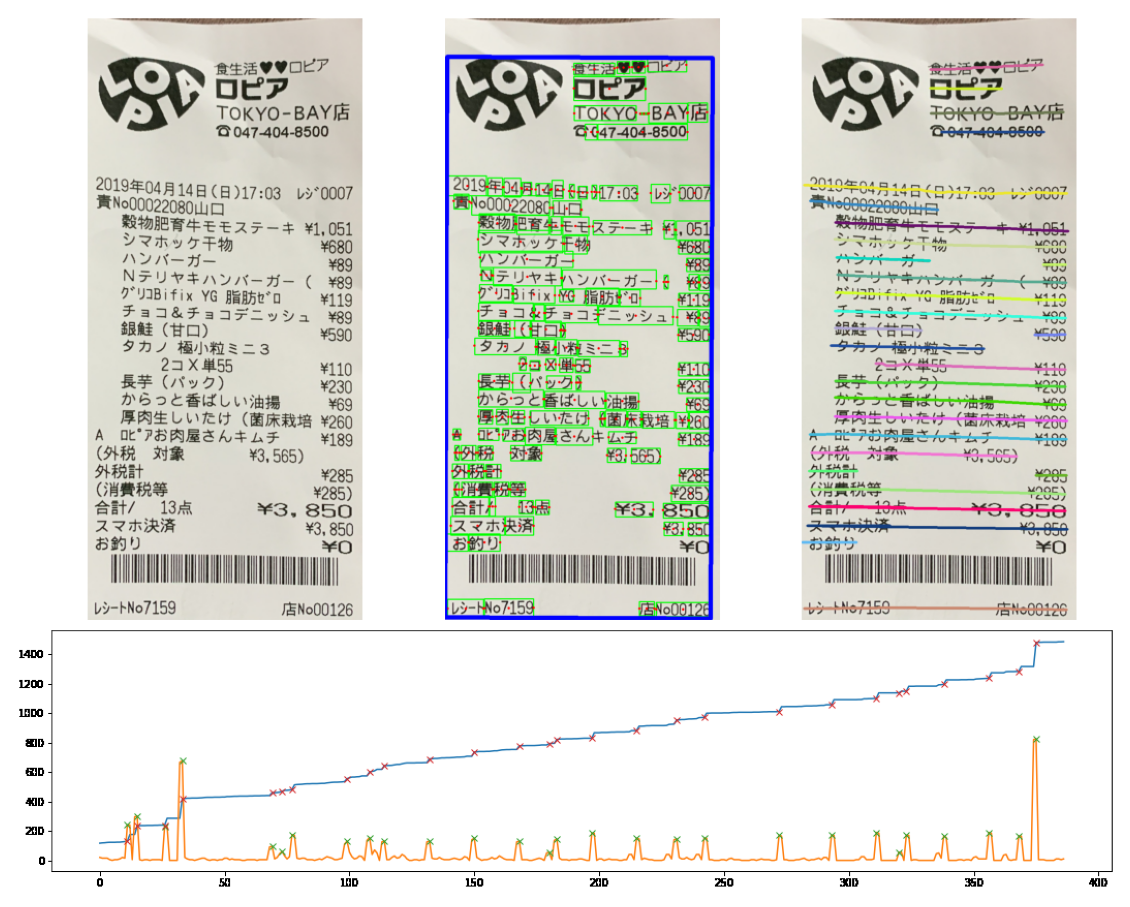

In [115]:
plt.figure(figsize=(20,20))
plt.imshow(img_res[:, :, [2, 1, 0]])
plt.axis('off')

In [106]:
str_text = ''.join([i for s in text_res for i in s])
text_res

[['食生活', '●', 'V', 'ロピア'],
 ['ロピア'],
 ['TOKYO', '-', 'BAY', '店'],
 ['a', '047-404-8500'],
 ['2019', '年', '04', '月', '14', '日', '(', '日', ')', '17:03', 'レジ', '0007'],
 ['責', 'NO00022080', '山口'],
 ['穀物', '肥育', '牛', 'モモ', 'ステーキ', '¥', '1,051'],
 ['シマホッケ', '千物', '¥680'],
 ['ハンバーガー'],
 ['¥89'],
 ['N', 'テリヤキ', 'ハンバーガー', '(', '¥', '89'],
 ['グリコ', 'Bifix', 'YG', '脂肪', 'ゼロ', '¥119'],
 ['チョコ', '&', 'チョコ', 'デニッシュ', '¥', '89'],
 ['銀鮭', '(', '甘口', ')'],
 ['¥590'],
 ['タカノ', '極', '小粒', 'ミニ', '3'],
 ['2', 'コ', 'X', '単', '55', '¥110'],
 ['長芋', '(', 'パック', ')', '¥230'],
 ['からっと', '香ばしい', '油揚', '¥69'],
 ['厚', '肉', '生', 'しいたけ', '(', '菌', '床', '栽培', '¥', '260'],
 ['A', 'ピア', 'お', '肉屋', 'さん', 'キムチ', '¥189'],
 ['(', '外', '税', '対象', '¥3,', '565)'],
 ['外', '税', '計'],
 ['¥285'],
 ['(', '消費', '税', '等', '¥285)'],
 ['合計', '/', '13', '点', '¥3,', '850'],
 ['スマホ', '決済', '¥3,', '850'],
 ['お', '釣り'],
 ['レシート', 'NO7159', '店', 'NO00126']]

In [107]:
# Time
pattern = '\d{2}:\d{2}'
result = re.findall(pattern, str_text) 
print(result)

# Date
pattern = '\d{4}/\d{1}/\d{1}'
result = re.findall(pattern, str_text) 
print(result)

pattern = '\d{4}/\d{2}/\d{2}'
result = re.findall(pattern, str_text) 
print(result)

pattern = '\d{4}年\d{1}月\d{1}'
result = re.findall(pattern, str_text) 
print(result)

pattern = '\d{4}年\d{2}月\d{2}'
result = re.findall(pattern, str_text) 
print(result)

# Phone number
pattern = '\d{3}-\d{3}-\d{4}'
result = re.findall(pattern, str_text) 
print(result)

pattern = '\d{4}-\d{2}-\d{4}'
result = re.findall(pattern, str_text) 
print(result)

pattern = '\(\d{3}\)\d{3}-\d{4}'
result = re.findall(pattern, str_text) 
print(result)

['17:03']
[]
[]
[]
['2019年04月14']
['047-404-8500']
[]
[]


In [108]:
if '8%' in str_text:
    print('8%')

In [109]:
total = []
for i in text_res:
    if '合計' in i:
        total.append(i)
total = [''.join(i) for i in total]
print(total)

['合計/13点¥3,850']


In [110]:
if 'クレジット' in str_text:
    print('Credit card')
elif 'お預り' in str_text:
    print('Cash')
elif 'プリカ' in str_text:
    print('Brica credit card')

In [111]:
price_items = []
for i in text_res:
    if '合計' in i or '小計' in i:
        break
    if (i[-1].isdigit() or '¥' in i[-1]) and len(i[-1])<5:
        price_items.append(i)

print(price_items)

res_price = []
for i in price_items[::-1]:
    if len(i[-1])<5 and len(i[-1])>1:
        res_price.append(i)
    else:
        break
res_price = res_price[::-1]
print(res_price)

[['2019', '年', '04', '月', '14', '日', '(', '日', ')', '17:03', 'レジ', '0007'], ['シマホッケ', '千物', '¥680'], ['¥89'], ['N', 'テリヤキ', 'ハンバーガー', '(', '¥', '89'], ['グリコ', 'Bifix', 'YG', '脂肪', 'ゼロ', '¥119'], ['チョコ', '&', 'チョコ', 'デニッシュ', '¥', '89'], ['¥590'], ['タカノ', '極', '小粒', 'ミニ', '3'], ['2', 'コ', 'X', '単', '55', '¥110'], ['長芋', '(', 'パック', ')', '¥230'], ['からっと', '香ばしい', '油揚', '¥69'], ['厚', '肉', '生', 'しいたけ', '(', '菌', '床', '栽培', '¥', '260'], ['A', 'ピア', 'お', '肉屋', 'さん', 'キムチ', '¥189'], ['¥285']]
[['2', 'コ', 'X', '単', '55', '¥110'], ['長芋', '(', 'パック', ')', '¥230'], ['からっと', '香ばしい', '油揚', '¥69'], ['厚', '肉', '生', 'しいたけ', '(', '菌', '床', '栽培', '¥', '260'], ['A', 'ピア', 'お', '肉屋', 'さん', 'キムチ', '¥189'], ['¥285']]
